# Build a serverless anomaly detection solution to predict results in realtime at scale

## Prerequisites
1. Choose same aws region for all services.
2. Create elemental media convert role => https://docs.aws.amazon.com/mediaconvert/latest/ug/creating-the-iam-role-in-iam.html

## Services used in this architecture:
1. Amazon Lookout for Vision
2. Amazon S3
3. Lambda
4. DynamoDB
5. Elemental Media Convert

## There are 2 workflows in this architecture: 
1. Images workflow 
2. Videos workflow

Using this architecture you can upload car images(png/jpeg) & car videos(e.g mp4) to predict damage defect as Anomalous or Normal in real time. You can store results in DynamoDB database for furture reference or analytics.

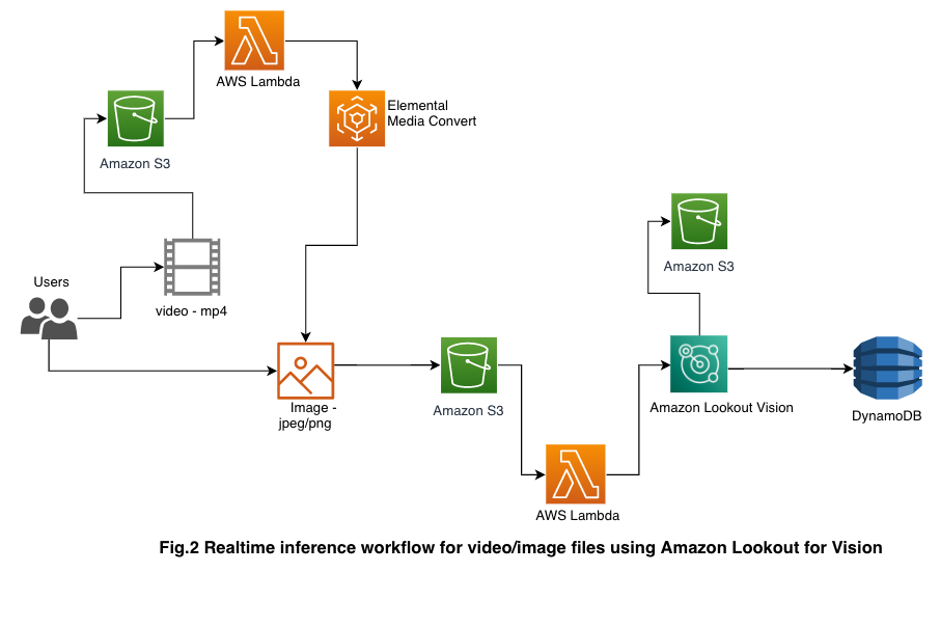

## Create two S3 Buckets in same region as Lookout for Vision:
1. Create first S3 bucket for uploading car videos => Video workflow input bucket.
2. Create a prefix "video_inputs" Underneath first s3 bucket.
3. Create second S3 bucket for uploading car images => Image workflow input bucket.
4. Create two prefixes "video_inputs" and "image_inputs" Underneath second s3 bucket.

## Create first Lambda Functions (using python 3.7 runtime)
1. First function name -> example "lo4v-video-to-image-conversion-using-elemental-media-convert"
2. Use below code snippet to create lambda function.
3. Create lambda function IAM role with permissions as S3FullAccess, CloudwatchfullAccess, ElementalMediaConvertFullAccess, Lambda Execution. 
##### Note: These permission are used for executing demo. For production setup, please set granular level of permisisons using least privilege model.
4. Add lambda trigger to first S3 bucket => First S3 bucket is used for uploading video file into prefix "video_inputs" as shown below.

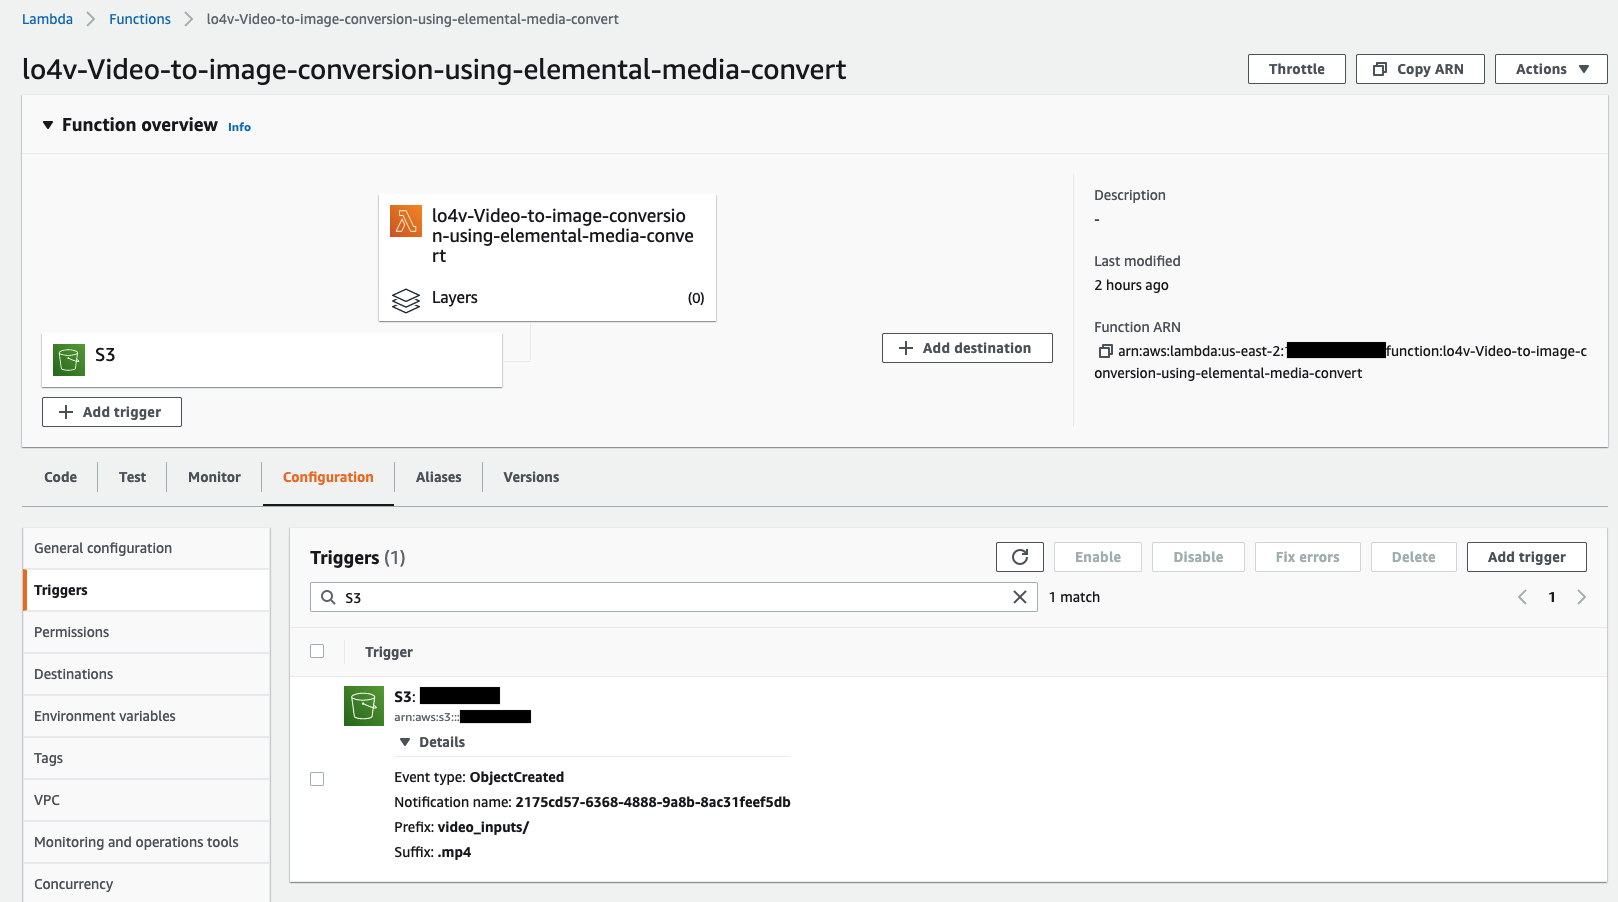

In [ ]:
#First Lambda function is used to trigger video workflow. This function is triggered by uploading car video file (example mp4) to S3. 
#First Lambda will trigger Amazon Elemental media convert job to capture image frames and store image results in destination S3 bucket. 

import json
import boto3

client = boto3.client('mediaconvert', endpoint_url = "https://wa11sy9gb.mediaconvert.us-east-2.amazonaws.com")     #To find your "elemental media convert" region speicifc endpoint check => https://docs.aws.amazon.com/general/latest/gr/mediaconvert.html, Here we have ohio region.

def lambda_handler(event, context):
  
  bucket_info = event["Records"][0]["s3"]
  bucket_name = bucket_info["bucket"]["name"]
  bucket_object = bucket_info["object"]["key"]
  
  input_url= "s3://"+bucket_name+"/"+bucket_object
  destination_url = "s3://<<Your_S3_Bucket>>/video_inputs/".    #It is destination S3 bucket used to store output of elemental media convert job. Output consists of images & parent video file. where "Video_inputs" is S3 prefix, used to store output image(s).
  
  
  response = client.create_job(AccelerationSettings={
        'Mode': 'DISABLED'},
    Queue="arn:aws:mediaconvert:<<Your_AWS_region>>:<<Your_AWS_Account_Number>>:queues/Default",    #Add your AWS account number & region.
    UserMetadata={},
    Role="arn:aws:iam::<<Your_AWS_Account_Number>>:role/service-role/MediaConvert_Default_Role",   #Add elemental media convert default role ARN, refer Prerequisites section.
    Settings={
    "TimecodeConfig": {
      "Source": "ZEROBASED"
    },
    "OutputGroups": [
      {
        "Name": "File Group",
        "Outputs": [
          {
            "ContainerSettings": {
              "Container": "RAW"
            },
            "VideoDescription": {
              "Width": 500,
              "ScalingBehavior": "DEFAULT",
              "Height": 500,
              "TimecodeInsertion": "DISABLED",
              "AntiAlias": "ENABLED",
              "Sharpness": 50,
              "CodecSettings": {
                "Codec": "FRAME_CAPTURE",
                "FrameCaptureSettings": {
                  "FramerateNumerator": 1,
                  "FramerateDenominator": 5,
                  "MaxCaptures": 4,
                  "Quality": 80
                }
              },
              "DropFrameTimecode": "ENABLED",
              "ColorMetadata": "INSERT"
            },
            "Extension": "jpg",
            "NameModifier": "jpg"
          },
          {
            "ContainerSettings": {
              "Container": "MP4",
              "Mp4Settings": {
                "CslgAtom": "INCLUDE",
                "CttsVersion": 0,
                "FreeSpaceBox": "EXCLUDE",
                "MoovPlacement": "PROGRESSIVE_DOWNLOAD",
                "AudioDuration": "DEFAULT_CODEC_DURATION"
              }
            },
            "VideoDescription": {
              "ScalingBehavior": "DEFAULT",
              "TimecodeInsertion": "DISABLED",
              "AntiAlias": "ENABLED",
              "Sharpness": 50,
              "CodecSettings": {
                "Codec": "H_264",
                "H264Settings": {
                  "InterlaceMode": "PROGRESSIVE",
                  "ScanTypeConversionMode": "INTERLACED",
                  "NumberReferenceFrames": 3,
                  "Syntax": "DEFAULT",
                  "Softness": 0,
                  "GopClosedCadence": 1,
                  "GopSize": 90,
                  "Slices": 1,
                  "GopBReference": "DISABLED",
                  "SlowPal": "DISABLED",
                  "EntropyEncoding": "CABAC",
                  "Bitrate": 1000,
                  "FramerateControl": "INITIALIZE_FROM_SOURCE",
                  "RateControlMode": "CBR",
                  "CodecProfile": "MAIN",
                  "Telecine": "NONE",
                  "MinIInterval": 0,
                  "AdaptiveQuantization": "AUTO",
                  "CodecLevel": "AUTO",
                  "FieldEncoding": "PAFF",
                  "SceneChangeDetect": "ENABLED",
                  "QualityTuningLevel": "SINGLE_PASS",
                  "FramerateConversionAlgorithm": "DUPLICATE_DROP",
                  "UnregisteredSeiTimecode": "DISABLED",
                  "GopSizeUnits": "FRAMES",
                  "ParControl": "INITIALIZE_FROM_SOURCE",
                  "NumberBFramesBetweenReferenceFrames": 2,
                  "RepeatPps": "DISABLED",
                  "DynamicSubGop": "STATIC"
                }
              },
              "AfdSignaling": "NONE",
              "DropFrameTimecode": "ENABLED",
              "RespondToAfd": "NONE",
              "ColorMetadata": "INSERT"
            },
            "AudioDescriptions": [
              {
                "AudioTypeControl": "FOLLOW_INPUT",
                "AudioSourceName": "Audio Selector 1",
                "CodecSettings": {
                  "Codec": "AAC",
                  "AacSettings": {
                    "AudioDescriptionBroadcasterMix": "NORMAL",
                    "Bitrate": 96000,
                    "RateControlMode": "CBR",
                    "CodecProfile": "LC",
                    "CodingMode": "CODING_MODE_2_0",
                    "RawFormat": "NONE",
                    "SampleRate": 48000,
                    "Specification": "MPEG4"
                  }
                },
                "LanguageCodeControl": "FOLLOW_INPUT"
              }
            ],
            "NameModifier": "mp4"
          }
        ],
        "OutputGroupSettings": {
          "Type": "FILE_GROUP_SETTINGS",
          "FileGroupSettings": {
            "Destination": destination_url
          }
        }
      }
    ],
    "AdAvailOffset": 0,
    "Inputs": [
      {
        "AudioSelectors": {
          "Audio Selector 1": {
            "Offset": 1,
            "DefaultSelection": "DEFAULT",
            "SelectorType": "TRACK",
            "ProgramSelection": 1
          }
        },
        "VideoSelector": {
          "ColorSpace": "FOLLOW",
          "Rotate": "DEGREE_0",
          "AlphaBehavior": "DISCARD"
        },
        "FilterEnable": "AUTO",
        "PsiControl": "USE_PSI",
        "FilterStrength": 0,
        "DeblockFilter": "DISABLED",
        "DenoiseFilter": "DISABLED",
        "InputScanType": "AUTO",
        "TimecodeSource": "ZEROBASED",
        "FileInput": input_url
      }
    ]},
    StatusUpdateInterval= "SECONDS_60",
    Priority = 0)
  print(response)

## Create Second Lambda Functions (using python 3.7 runtime)
1. Second function name -> example "lo4v-image-detect_defect-write_to_dynamodb"
2. Use below code snippet to create lambda function.
3. Create lambda function IAM role with permission as S3FullAccess, CloudwatchfullAccess, DynamoDBFullAccess, LookoutVisionFullAccess, Lambda Execution. 
##### Note: These permission are used for executing demo. For production setup, please set granular level of permisisons using least privilege model.
4. Below lambda function also has three environment variables:-
##### model_version =  <<1>>   => This is your lookout for vision model version. Please check you model version using lookout for vision service console. If you have only one trained model than it should be 1.
##### output_bucket =	<<"S3-Output-bucket-name">> => S3 output bucket to store results.
##### project_name  = <<"Detect-Defect-Car-2">>  => Check lookout for vision project name. Refer service console or previous notebook.
5. ADD two lambda triggers using second S3 bucket as shown below. 
###### A. For using Video workflow output, remember we used first lambda function for converting video input files (mp4) to output images (jpeg). 
###### B. For using Image workflow, where direct car images are uploaded to second S3 bucket under prefix "image_inputs")
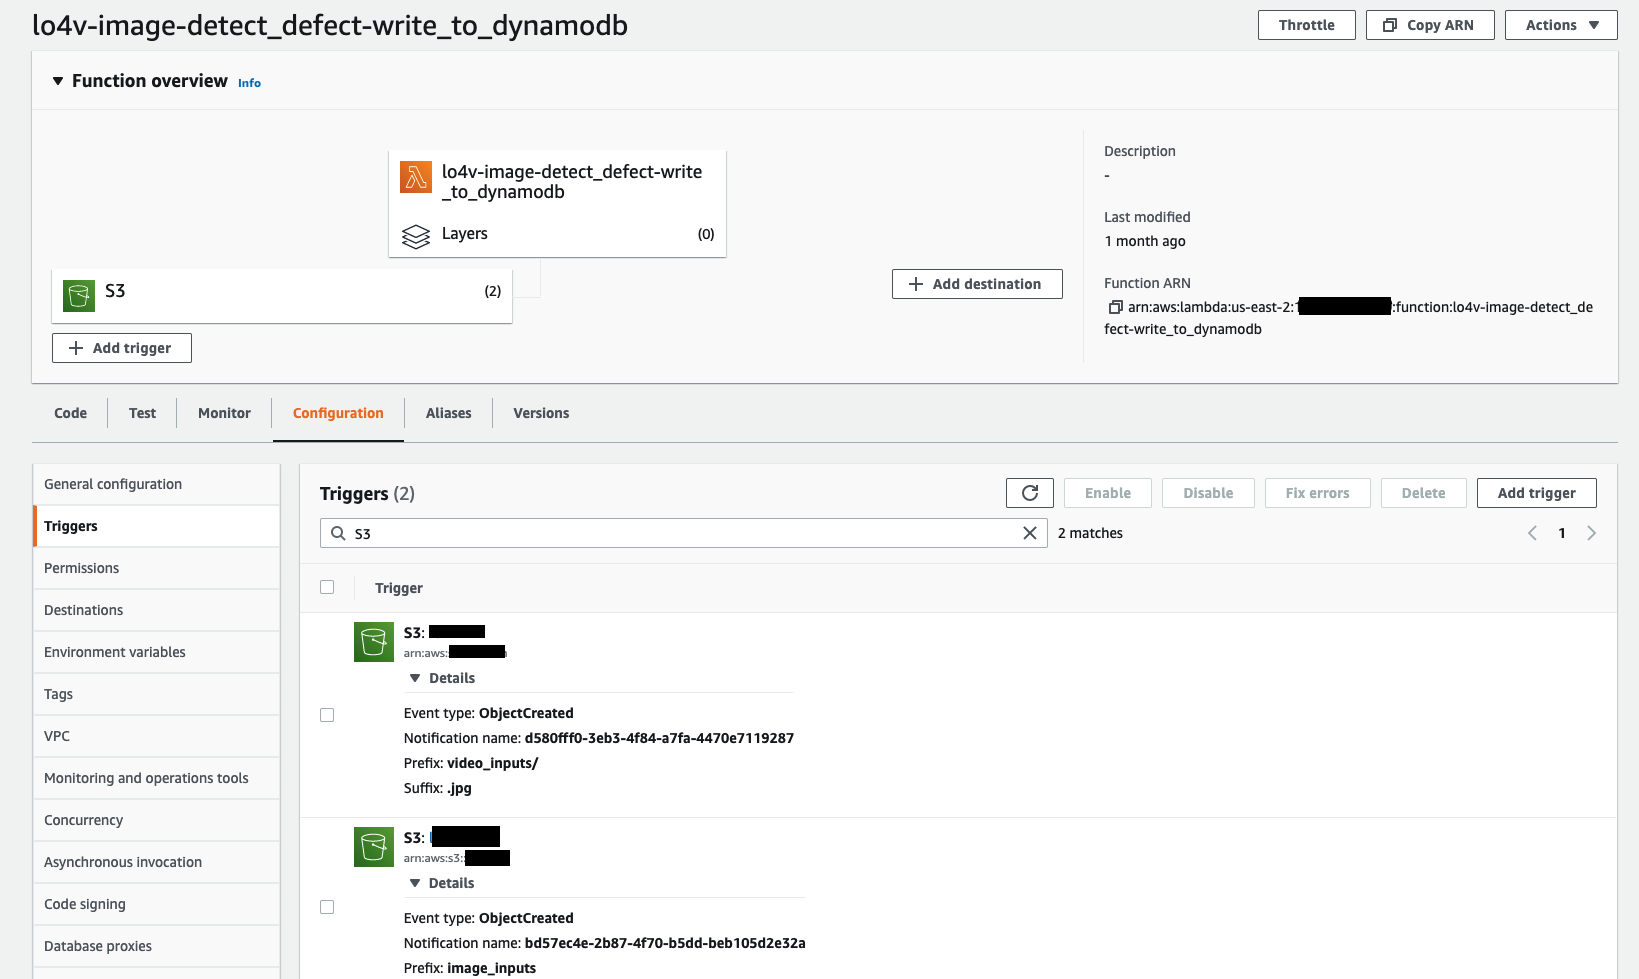

In [ ]:
#Create second lambda function. Upload car images to S3 bucket or use first lambda function to convert car video files to car images using elemental media convert & store image results in S3. 
#After upload of images to S3, this lambda function will be triggered.
#Here we are using lookout for vision "detect anomalies" api to inspect the images & store result in S3 & dynamoDB table.

import json
import os
import boto3
import base64
from subprocess import call

#S3, dynamodb and lookout for vision client initialisations outside handler for resuse
s3 = boto3.resource('s3')
lv_client = boto3.client('lookoutvision')

ddb_client = client = boto3.client('dynamodb')

def download_file_from_s3(bucket_name,key):
    
    file_name = key.split("/")[-1]
    file_in_tmp = "/tmp/" + file_name
    s3.Bucket(bucket_name).download_file(key, file_in_tmp)
    
    # print("After download : ")
    # os.system("ls /tmp")
    
    return file_in_tmp

def check_content_type(abc):
    return "image/jpeg" if abc.lower().split(".")[-1] in ["jpeg","jpg",] else "image/png"

#Using lookout for vision detect anomalies api to inspect jpeg or png images.

def check_for_anomaly(img,content_type):
    #print(content_type)
    with open(img, 'rb') as img_f:
        response = lv_client.detect_anomalies(
                ProjectName=os.environ["project_name"],
                ModelVersion=os.environ["model_version"],
                Body=bytearray(img_f.read()),
                ContentType=content_type)
    
        return(response)

#writing results to DynamoDB table.
        
def write_to_ddb(result,image_name):
    RequestID = result["ResponseMetadata"]["RequestId"]
    Date = result["ResponseMetadata"]["HTTPHeaders"]["date"]
    DetectAnomalyResult = result["DetectAnomalyResult"]["IsAnomalous"]
    Confidence = result["DetectAnomalyResult"]["Confidence"]
    
    print(result)
    
    response = ddb_client.put_item(
    Item={
        'RequestID': {
            'S': RequestID,
        },
        'Date': {
            'S': Date,
        },
        'DetectAnomalyResult': {
            'S': str(DetectAnomalyResult),
        },
        'Confidence' : {
            'S' : str(Confidence)
        },
        'Image' :{
            'S' : str(image_name)
        }
    },
    TableName='lookout_for_vision_summary')     #Replace 'lookout_for_vision_summary' with your dynamoDB table name.
    
    
        
def parse_result_s3(result,output_bucket,output_key):
    output_file = open("/tmp/output.txt", "w")
    output_file.write(json.dumps(result))
    output_file.close()
    
    s3.meta.client.upload_file('/tmp/output.txt', output_bucket, output_key)

def clear_tmp_directory():
    # print("before clearing")
    # os.system("ls /tmp")
    
    call('rm -rf /tmp/*', shell=True)
    
    # print("after clearing")
    # os.system("ls /tmp")

def lambda_handler(event, context):
    
    #parse out the bucket and object names
    bucket_name = event['Records'][0]['s3']['bucket']['name']
    key = event['Records'][0]['s3']['object']['key']
    
    print(event)
    print(bucket_name)
    print(key)
    
    #downloads the image to Lambda's /tmp directory (Parameters : bucket name and object name of the input image)
    file_in_tmp = download_file_from_s3(bucket_name,key)
    
    #check the content type of the file (image/jpeg or image/png)
    content_type = check_content_type(key.split(".")[-1])
    
    #Detects anomalies in the input image (Parameter : input path of the image)
    result = check_for_anomaly(file_in_tmp,content_type)
    print(result)
    
    #Write results to DynamoDB
    write_to_ddb(result,key.split("/")[-1])
    
    #parse the result and write to s3
    output_key = key.split("/")[-1]+".txt"
    parse_result_s3(result,os.environ["output_bucket"],output_key)
    
    # Clear /tmp directory. Container reuse can cause filling up of /tmp directory causing out of memory issues
    clear_tmp_directory()

## Create DynamoDB Table

1. Create DynamoDB table => Table Name e.g "lookout_for_vision_summary" with default settings. 
2. Use primary partition key value as "RequestID" type String. Where request id captures lambda function id details.
3. Note DynamoDB Table name.

## Implementations steps

1. User uploads image(s) or videos in form .mp4 or jpeg/png formats (same dimension size as training images) to S3. This will use either or both lambda workflows.
2. For video workflow (.mp4 file) s3 trigger first lambda to start elemental media convert job to capture frames & save as multiple jpeg images in s3.
3. For jpeg/png workflow, S3 triggers a second lambda function. It initiates lookout for vision client & use detect defect api to inspect input image(s). Finally identify image as either "normal" or "anomalus".
4. Write results in S3 & dynamodb.
5. Use Lookout for Vision Dashboard & key metrics like "total number of anomalies", "total image processed" & total anomaly ratio.

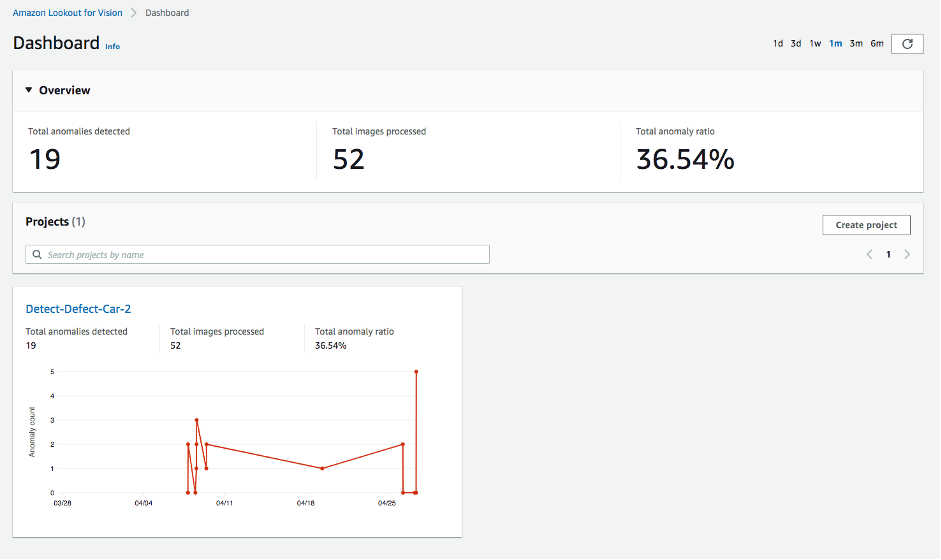

6. To get more insights from each image like image name, confidence score, anomaly result, date etc. We are recording results in DynamoDB table for each image. Dynamodb table provide more visibility on predicted datapoints for each image, it help in achieving deeper inspection. In other words, with DynamoDB table you can record & track down the defected image metadata & results for further action.
DynamoDB Table:
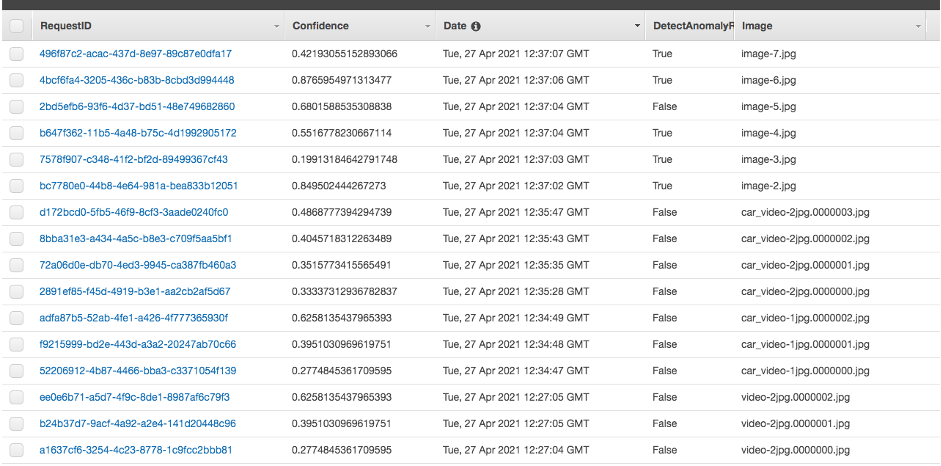

7.	Stop Model (Model status will change from “Hosted” to “Training Complete”) This will help to save cost of ML resources.
Use below snippets:

aws lookoutvision stop-model \
  --project-name Detect-Defect-Car-2 \
  --model-version 1

Output:- Verify using lookout for vision service console.

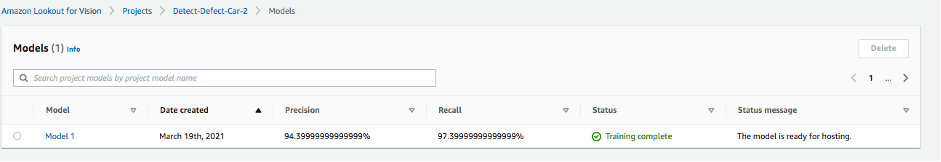